# **Distributed Processing Challenges: Handling Data Skew in RDD PySpark**





In [4]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=59dcb524bec563ed921872bc4a653b561b47809ccb4840e6445035e45629341a
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [6]:
from pyspark import SparkContext, SparkConf

conf = SparkConf().setAppName("Test").setMaster('local[*]')
sc = SparkContext(conf = conf)


In [ ]:
# Load Spark engine
!pip3 install -q findspark
import findspark
findspark.init()

from pyspark import SparkContext, SparkConf

# Initializing Spark
conf = SparkConf().setAppName("Skew").setMaster("local[*]")
sc = SparkContext(conf=conf)

## Loading Data Skew

To understand skew, we create a random data where keys are uniformly distributed.

In [19]:
data_sample = [(1,4), (2,2), (2,1), (3,5), (2,5), (2,10), (2,7), (3,4), (2,1), (2,4), (4,4)]
#sc.parallelize(data_sample, 3)


import numpy as np
import random

key_1 = ['a'] * 10
key_2 = ['b'] * 6000000
key_3 = ['c'] * 800
key_4 = ['d'] * 10000

keys = key_1 + key_2 + key_3 + key_4
random.shuffle(keys)

values_1 = list(np.random.randint(low = 1, high = 100, size = len(key_1)))
values_2 = list(np.random.randint(low = 1, high = 100, size = len(key_2)))
values_3 = list(np.random.randint(low = 1, high = 100, size = len(key_3)))
values_4 = list(np.random.randint(low = 1, high = 100, size = len(key_4)))

values = values_1 + values_2 + values_3 + values_4


keys_values = list(zip(keys, values))


In [20]:
rdd = sc.parallelize(keys_values, 8)




## (1) Run a shuffle `groupByKey()` to see how the skew effects computation resources.

In [ ]:
data_sample_grouped = data_sample.groupByKey()


#groupBy results
for key in data_sample_grouped.collect():
  print(key[0], (value for value in key[1]))

#to print partitions
data_sample_grouped.glom().collect()


In [ ]:
grouped_rdd = rdd.groupByKey().cache()

# run a simple data transformation (using map()) on the skewed data
grouped_rdd.map(lambda pair:(pair[0], [(i+10) for i in pair[1]])).count()

## Mitigate data skewness: SALTING

In [ ]:
# salting function:

def salting(val):
  tmp = val + '_' + str(np.random.randint(low = 1, high =5))
  return tmp

salting('salah')

'salah_4'

In [ ]:
# salting method:

rdd_salting = rdd.map(lambda x: (salting(x[0]), x[1]))

# actual code
grouped_rdd = rdd_salting.groupByKey().cache()
# run a simple data transformation (using map()) on the skewed data
grouped_rdd.map(lambda pair:(pair[0], [(i+10) for i in pair[1]])).count()


## (2) Run a shuffle `sortByKey()` to see how the skew effects computation resources.

In [ ]:
rdd_sort = rdd.sortByKey(ascending=False, numPartitions=4)
rdd_sort.count()



## Mitigate data skewness: SALTING

In [ ]:
rdd_sort = rdd_salting.sortByKey(ascending=False, numPartitions=4)
rdd_sort.count()

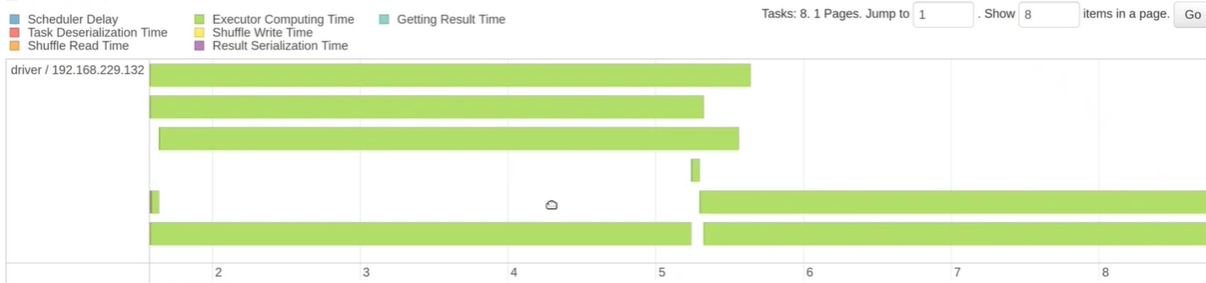

## (3) Run a shuffle `Join()` to see how the skew effects computation resources.

In [7]:
small_rdd1 = sc.parallelize([(2,3), (1,3), (1,4), (3,1), (5,1)], 3)
small_rdd2 = sc.parallelize([(5,3), (2,3), (1,5),], 2)

print(small_rdd1.collect())
print(small_rdd2.collect())




[(2, 3), (1, 3), (1, 4), (3, 1), (5, 1)]
[(5, 3), (2, 3), (1, 5)]


In [12]:
join_rdd = small_rdd1.join(small_rdd2)

join_rdd.glom().collect()

[[(5, (1, 3))], [(1, (3, 5)), (1, (4, 5))], [(2, (3, 3))], [], []]

In [15]:
#generate normal data


key_1 = ['a'] * 5
key_2 = ['b'] * 60
key_4 = ['d'] * 100

keys = key_1 + key_2 + key_4
random.shuffle(keys)


values_1 = list(np.random.randint(low = 1, high = 100, size = len(key_1)))
values_2 = list(np.random.randint(low = 1, high = 100, size = len(key_2)))
values_4 = list(np.random.randint(low = 1, high = 100, size = len(key_4)))

values = values_1 + values_2 + values_4

pair_data = list(zip(keys, values))


In [16]:
#put inside RDD

small_rdd = sc.parallelize(pair_data, 2)

In [23]:
#join without salting

join_rdd_nosalting = rdd.join(small_rdd)

join_rdd_nosalting.map(lambda x: int(x[1][0] + x[1][1])).reduce(lambda a,b: a+b)



36786097035

# **It took 4 minutes to complete the computation for reduce.**

## Mitigate data skewness: SALTING

In [24]:
# add random values to the key -> (key, random int)

rdd_new = rdd.map(lambda x: (x[0], random.randint(0,10), x[1])).cache()

#replicate small data
small_rdd_new = small_rdd.cartesian(sc.parallelize(range(0,11))).map(lambda x: (x[0][0], x[1], x[1][1])).cache()

In [ ]:
# Join with salting

rdd_join = rdd_new.join(small_rdd_new)
rdd_join.map(lambda x: int(x[1][0] + x[1][1])).reduce(lambda a,b: a+b)

# **It took 28 seconds to complete the computation for reduce.**